<a href="https://colab.research.google.com/github/TooPercentMilk/MoGen/blob/main/BERT_VER2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialization

In [ ]:
!pip install portalocker
!pip install transformers
!pip install datasets

In [ ]:

from google.colab import drive
from transformers import BertTokenizer, BertModel, get_scheduler, DistilBertTokenizer, DistilBertModel

from datasets import Dataset
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from torch import nn
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

import seaborn as sns
import matplotlib.pyplot as plt

import torchtext
import numpy as np
import pandas as pd
import torch
import ast
import os
import sys

#model_name = "bert-base-uncased"
model_name = "distilbert-base-uncased"

drive.mount('/content/drive')
GOOGLE_DRIVE_PATH = '/content/drive/MyDrive/MoviePrediction'
os.chdir(GOOGLE_DRIVE_PATH)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cuda


# Dataset Prep

In [ ]:
datasetRAW = pd.read_csv('train.csv')
datasetRAW.head(5)

,id,movie_name,synopsis,genre
0,44978,Super Me,A young scriptwriter starts bringing valuable ...,fantasy
1,50185,Entity Project,A director and her friends renting a haunted h...,horror
2,34131,Behavioral Family Therapy for Serious Psychiat...,This is an educational video for families and ...,family
3,78522,Blood Glacier,Scientists working in the Austrian Alps discov...,scifi
4,2206,Apat na anino,Buy Day - Four Men Widely - Apart in Life - By...,action


In [ ]:
idx = 35111
print(datasetRAW.iloc[idx]['movie_name'])
print(datasetRAW.iloc[idx]['synopsis'])
print(datasetRAW.iloc[idx]['genre'])

The Devil in the Room
A young couple look to prevent an evil spirit from trapping their souls in the realm between sleep and reality.
horror


In [ ]:
len(datasetRAW)

54000

In [ ]:
genre = sort(datasetRAW['genre'].tolist()
synop = datasetRAW['synopsis'].tolist()
name = datasetRAW['movie_name'].tolist()
nameSynop = []

for i in range(len(genre)):
  nameSynop.append(name[i].lower() + " : " + synop[i].lower())

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-44-90b8da63e138>", line 1, in <cell line: 1>
    genre = sort(datasetRAW['genre'].tolist())
NameError: name 'sort' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/python3.10/dist-packa

In [ ]:
genreLabels = []
genreList = []
cnt = 0
GenreToLabel = dict()
for curGenre in genre:
  if curGenre not in GenreToLabel:
    genreList.append(curGenre)
    GenreToLabel[curGenre] = cnt
    cnt = cnt + 1
  genreLabels.append(GenreToLabel[curGenre])

In [ ]:
datasetDict = dict()
datasetDict = {'label': genreLabels, 'text': nameSynop}

dataset = Dataset.from_dict(datasetDict,split="train+test")
dataset = dataset.train_test_split(test_size=.3, shuffle=True)

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

In [ ]:
#tokenizer = BertTokenizer.from_pretrained(model_name)
tokenizer = DistilBertTokenizer.from_pretrained(model_name)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/37800 [00:00<?, ? examples/s]

Map:   0%|          | 0/16200 [00:00<?, ? examples/s]

In [ ]:
#small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(35000))
#small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(8000))
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42)
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(int(len(tokenized_datasets["test"]) / 2)))
smaller_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(500))

In [ ]:
train_dataloader = DataLoader(small_train_dataset, shuffle=True, batch_size=32)
eval_dataloader = DataLoader(small_eval_dataset, batch_size=16)
small_eval_dataloader = DataLoader(smaller_eval_dataset, batch_size=16)

In [ ]:
next(iter(train_dataloader))

{'label': tensor([6, 9, 7, 4, 2, 3, 5, 2, 0, 9, 4, 3, 5, 9, 5, 8, 6, 5, 1, 5, 7, 8, 1, 0,
         3, 1, 9, 0, 1, 9, 2, 2]),
 'input_ids': tensor([[  101,  2175,  6632,  ...,     0,     0,     0],
         [  101, 11937,  3501,  ...,     0,     0,     0],
         [  101,  6343, 25126,  ...,     0,     0,     0],
         ...,
         [  101, 10047,  2000,  ...,     0,     0,     0],
         [  101, 22518,  1024,  ...,     0,     0,     0],
         [  101, 10210, 17157,  ...,     0,     0,     0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]])}

# Model Initialization

In [ ]:
class ModelForClassification(nn.Module):

  def __init__(self, class_model: BertModel, hidden_dim: int, num_pos:int):

    super().__init__()

    self.layer = nn.Linear(hidden_dim, num_pos)
    self.class_model = class_model

  def forward(self, input_ids: torch.Tensor, attention_mask: torch.Tensor):

    hidden_states = self.class_model(input_ids, attention_mask).last_hidden_state[:, 0]
    output = self.layer(hidden_states)

    return output


In [ ]:
#languageModel = BertModel.from_pretrained(model_name).to(device)
languageModel = DistilBertModel.from_pretrained(model_name).to(device)
model = ModelForClassification(languageModel, languageModel.config.hidden_size, cnt).to(device)

In [ ]:
learning_rate = 1e-5
weight_decay = 0


loss_func = nn.CrossEntropyLoss()
optimizer  =  torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


## Model Training

In [ ]:
isGraph = True

train_loss_ind = []
train_loss_graph = []
val_loss_ind = []
val_loss_graph = []

loss_freq = 1/8

In [ ]:
def train_model(net, trn_loader, val_loader, optim, loss_fn, num_epochs=2, device = 'cpu', verbose = True):

  numTrnStps = num_epochs * len(trn_loader)

  progress_bar = tqdm(range(numTrnStps))
  lr_scheduler = get_scheduler(name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=numTrnStps)

  for epoch in range(num_epochs):
    print('epoch:', epoch)

    net.train()

    total_correct = 0
    total_predicted = 0
    lossList = []

    batch_cnt = 0
    next_threshold = 0
    partialLoss = []

    for batch in trn_loader:
      batch = {k: v.to(device) for k, v in batch.items()}

      outputs = net.forward(batch['input_ids'], batch['attention_mask'])

      loss = loss_fn(outputs,batch['label'] )
      loss.backward()


      optimizer.step()
      lr_scheduler.step()
      optimizer.zero_grad()
      progress_bar.update(1)

      _, predicted = torch.max(outputs, 1)
      total_correct += (predicted == batch['label']).sum().item()
      total_predicted += len(predicted)

      lossList.append(loss.item())
      partialLoss.append(loss.item())
      batch_cnt = batch_cnt + 1
      if (batch_cnt / len(trn_loader) >  next_threshold) and isGraph:
        train_loss_ind.append( (batch_cnt / len(trn_loader)) + epoch )
        val_loss_ind.append( (batch_cnt / len(trn_loader)) + epoch )
        train_loss_graph.append( sum(partialLoss) / len(partialLoss))
        partialLoss = []
        val_loss_graph.append( get_validation_performance(net, loss_fn, small_eval_dataloader, device, False) )
        next_threshold = next_threshold + loss_freq


    lossVal = sum(lossList) / len(lossList)
    accuracy = total_correct / total_predicted
    print("training loss:", lossVal, " training accuracy:", accuracy)
    get_validation_performance(net, loss_fn, val_loader, device, True)




In [ ]:
def get_validation_performance(net, loss_fn, val_loader, device, outputB):

  net.eval()
  with torch.no_grad():
    lossList = []
    total_correct = 0
    total_predicted = 0
    allPredicts = []
    allLabels = []

    confusionMatrix = np.zeros((10,10))
    for batch in val_loader:
      batch = {k: v.to(device) for k, v in batch.items()}

      outputs = net.forward(batch['input_ids'], batch['attention_mask'])
      loss = loss_fn(outputs,batch['label']).item()

      lossList.append(loss)

      _, predicted = torch.max(outputs, 1)
      total_correct += (predicted == batch['label']).sum().item()
      total_predicted += len(predicted)

      allPredicts = allPredicts + list(predicted.cpu())
      allLabels = allLabels + list(batch['label'].cpu())

    lossVal = sum(lossList) / len(lossList)
    accuracy = total_correct / total_predicted


    if outputB:
      precision, recall, fscore, _ = precision_recall_fscore_support(allLabels, allPredicts, average='macro')
      print('validation loss:', lossVal, ' validation accuracy:', accuracy)
      print('Precision:', precision, ' Recall:', recall, ' FScore:', fscore)

      cm = confusion_matrix(allPredicts, allLabels)
      sns.heatmap(cm,
              annot=True,
              fmt='g',
              xticklabels=genreList,
              yticklabels=genreList)
      plt.ylabel('Prediction',fontsize=13)
      plt.xlabel('Acutal',fontsize=13)
      plt.title('BERT',fontsize=17)
      plt.show()

    return lossVal


validation loss: 1.6236044645779701  validation accuracy: 0.41814814814814816
Precision: 0.4070061625673653  Recall: 0.41743855421945336  FScore: 0.40653530308154295


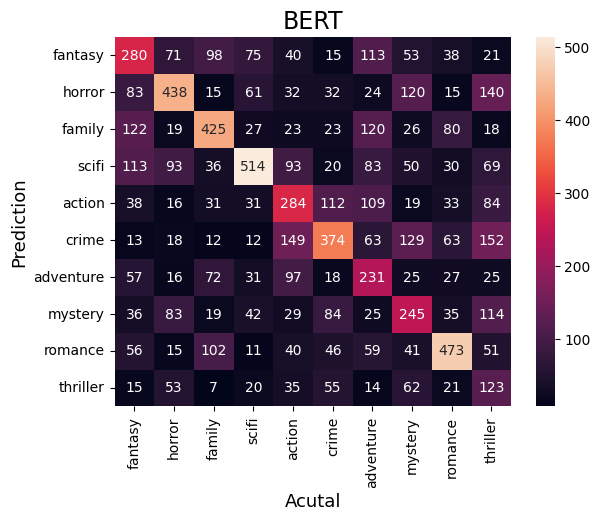

1.6236044645779701

In [ ]:
get_validation_performance(model, loss_func, eval_dataloader, device, True)

  0%|          | 0/2364 [00:00<?, ?it/s]

epoch: 0
training loss: 1.7392578592962016  training accuracy: 0.37883597883597886
validation loss: 1.6365190932501468  validation accuracy: 0.4150617283950617
Precision: 0.4071269599122623  Recall: 0.4138806055689236  FScore: 0.40298968126488355


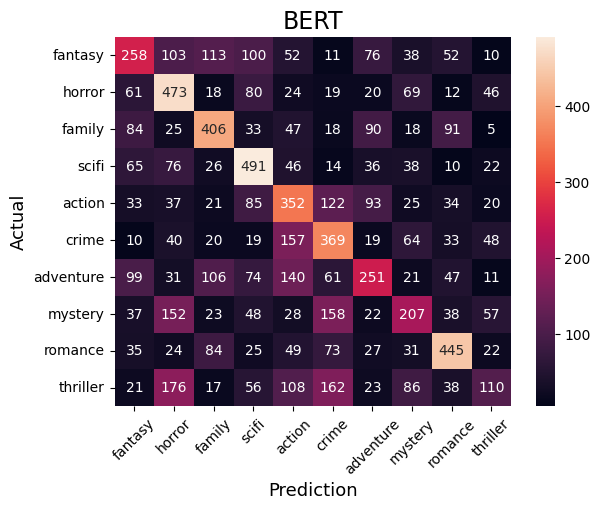

epoch: 1
training loss: 1.5346243435961342  training accuracy: 0.4537830687830688
validation loss: 1.6236044645779701  validation accuracy: 0.41814814814814816
Precision: 0.4070061625673653  Recall: 0.41743855421945336  FScore: 0.40653530308154295


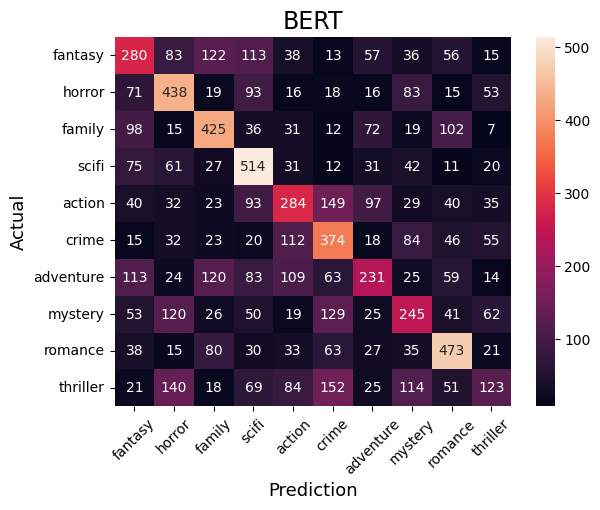

In [ ]:
train_model(model, train_dataloader, eval_dataloader, optimizer,loss_func, 2, device, True)

In [ ]:
train_loss_ind.append(2)
val_loss_ind.append(2)
train_loss_graph.append(1.5346243435961342)
val_loss_graph.append(1.6236044645779701)

In [ ]:
val_loss_ind

[0.0,
 0.125,
 0.25,
 0.375,
 0.5,
 0.625,
 0.75,
 0.875,
 1.0,
 1.125,
 1.25,
 1.375,
 1.5,
 1.625,
 1.75,
 1.875,
 2]

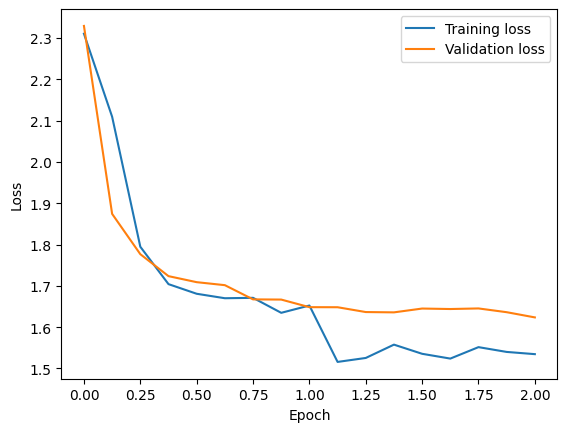

In [ ]:
plt.plot(train_loss_ind, train_loss_graph, label='Training loss')
plt.plot(val_loss_ind, val_loss_graph, label='Validation loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
len(train_loss_graph)

16

In [ ]:
val_loss_ind = train_loss_ind

In [ ]:
for i in range(len(train_loss_ind)):
  train_loss_ind[i] = i * loss_freq

In [ ]:
val_loss_graph

[2.3294187262654305,
 1.874284353107214,
 1.7767105028033257,
 1.7235160246491432,
 1.7089191637933254,
 1.7016687504947186,
 1.6672568172216415,
 1.666794341057539,
 1.6483903117477894,
 1.6482332795858383,
 1.6365681923925877,
 1.6358101963996887,
 1.645053967833519,
 1.6438943110406399,
 1.6453163772821426,
 1.6362150348722935]